# Transfer Learning - Project

## Student Identity

In [1]:
# @title #### Student Identity
student_id = "REA3X5EN"  # @param {type:"string"}
name = "Steven Adi Santoso"  # @param {type:"string"}
drive_link = "https://drive.google.com/drive/folders/1l47IYqGVXotwnxm0gh-VBgyzKQnwbyRI?usp=sharing"  # @param {type:"string"}

## Import package

In [2]:
!pip install rggrader
from rggrader import submit, submit_image


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Task 1: Transfer Learning for Emotion Recognition

In this project, you will use a [Vision Transformer (ViT)](https://huggingface.co/google/vit-base-patch16-224-in21k) model pre-trained on ImageNet-21k and fine-tune it on the [FastJobs/Visual_Emotional_Analysis](https://huggingface.co/datasets/FastJobs/Visual_Emotional_Analysis) dataset for emotion recognition, with the final step being the publication of your trained model to the Hugging Face Model Hub.

### Step 1: Environment Setup

In this section, we start by installing the necessary packages and logging into Hugging Face's platform:
- `transformers`
- `datasets`
- `evaluate`
- `huggingface_hub`

In [3]:
# Install necessary packages

# Put your code here:
!pip install transformers
!pip install scikit-learn
!pip install datasets 
!pip install evaluate 
!pip install accelerate 
!pip install huggingface_hub
!pip install accelerate
!pip install gradio

import numpy as np

import evaluate
from huggingface_hub import login

from datasets import load_dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    ViTFeatureExtractor,
    TrainingArguments,
    Trainer,
    DefaultDataCollator
)

from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

from PIL import Image

import matplotlib.pyplot as plt

import gradio as gr
# ---- End of your code ----

After installing, use the Hugging Face's notebook login function to log into Hugging Face's platform. Execute the following commands in your cell:

In [4]:
# Log into Hugging Face's platform

# Put your code here:
login()
# ---- End of your code ----

### Step 2: Load the Dataset

Load the "FastJobs/Visual_Emotional_Analysis" dataset and split it into training and test sets with a test size of 0.2.

> **Note**: please assign to variable `emotion`

In [5]:
# Load the dataset and split it

# Update your code here:
emotion = load_dataset(
    path="FastJobs/Visual_Emotional_Analysis",
    cache_dir="./dataset"
)
# ---- End of your code ----

Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

**Label Mapping**

> **Note**: no need to change the code below! Just run it to map labels from the dataset.

In [6]:
labels = emotion["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

### Step 3: Explore and Visualize the Dataset

In this step, you are required to visualize the first instance in the training dataset.

> **Note**: no need to change the code below! Just run it to visualize the dataset based on index.

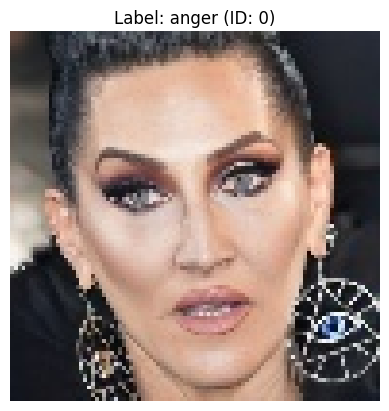

In [7]:
# Define the function to convert label index to label name
id2label_view = {str(i): label for i, label in enumerate(labels)}

# Use first training example
image = emotion['train'][0]['image']  # Explore image by index
label_id = str(emotion['train'][0]['label'])
label_name = id2label_view[label_id]

# Display the image and its corresponding label
plt.imshow(image)
plt.title(f'Label: {label_name} (ID: {label_id})')
plt.axis('off')
plt.show()

### Step 4: Preprocess the Data

You need to define the transformation function for image preprocessing and apply it to the dataset.

In [8]:
# Load the image processor, Define the transforms, Define the transformation function and Apply the transformation function

# Put your code here:
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean = image_processor.image_mean
image_std = image_processor.image_std
size = image_processor.size["height"]

# Create the image transforms
_transforms = Compose([
    RandomResizedCrop(size),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])

# Define the function that will be applied to the dataset
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

# Apply the function to the dataset
emotion.set_transform(transforms)
# ---- End of your code ----

### Step 5: Model Setup

In this step, define the model architecture with the pre-trained ViT model and load it.

In [9]:
# Define the model

# Put your code here:
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    cache_dir="./checkpoint",
    num_labels=len(id2label),
    label2id=label2id,
    id2label=id2label
)
# ---- End of your code ----

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Step 6: Training Setup

Define the training arguments and instantiate the trainer.

In [10]:
# Load accuracy metric

# Put your code here:
accuracy = evaluate.load("accuracy")
# ---- End of your code ----

In [11]:
# Define compute metric function

# Put your code here:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return accuracy.compute(predictions=predictions, references=labels)

# ---- End of your code ----

In [12]:
# Define training arguments

# Update your code here:
training_args = TrainingArguments(
    output_dir="model/vit-emotions-fp16",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    fp16=True,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)
# ---- End of your code ----

ValueError: FP16 Mixed precision training with AMP or APEX (`--fp16`) and FP16 half precision evaluation (`--fp16_full_eval`) can only be used on CUDA or NPU devices or certain XPU devices (with IPEX).

To use Hugging Face `Trainer` you need to install the `accelerate` library version `0.20.1` or later. It is used for performance enhancement on PyTorch.

In [13]:
 # Instantiate the trainer

# Update your code here:
data_collator = DefaultDataCollator()

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=emotion["train"],
    eval_dataset=emotion["train"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)
# ---- End of your code ----

NameError: name 'training_args' is not defined

If there are problems when using the Trainer after installing `accelerate` you can restart the Kernel

### Step 7: Train and Evaluate the Model

Now, you are ready to train the model and evaluate it on the test set.

In [ ]:
# Train the model

# Put your code here:
trainer.train()  # I did the training in google colab
# ---- End of your code ----

In [ ]:
# Evaluate the model

# Update your code here:
eval_result = trainer.evaluate(eval_dataset=emotion["train"])  # 0.80125
# ---- End of your code ----

# Save the formatted accuracy in a variable
accuracy_str = "{:.4f}".format(eval_result["eval_accuracy"])

### Step 8: Publishing the Trained Model

Finally, make sure to push your trained model to the Hugging Face Model Hub.

> **Note**: No need to change the code below! Just run to publish your model.

In [ ]:
trainer.push_to_hub()

Once you've trained your model and pushed it to the Hugging Face Model Hub, you'll have a link that points directly to your model's page. You can share this link with others, and they can use it to directly load your model for their own uses.

The following link is an example of what a trained model's page looks like: https://huggingface.co/aditira/emotion_classification. This is not your model, but rather an example of what your final result might resemble.

Remember, for this project you should push your output model to your own Hugging Face account. The link for your model will be different and should reflect your own username and model name.

In [14]:
# Submit Method
huggingface_model_link = "https://huggingface.co/silvering/vit-emotions-fp16"  # Put your model link

assignment_id = "00_transfer_learning"
question_id = "00_emotion_recognition_huggingface"
submit(student_id, name, assignment_id, huggingface_model_link, question_id, drive_link)

question_id = "01_emotion_recognition_accuracy"
submit(student_id, name, assignment_id, accuracy_str, question_id, drive_link)

'Assignment successfully submitted'

## Task 2:  Build an Interactive Application with Gradio

In this task, you will be building an interactive application using Gradio that will use your fine-tuned emotion recognition model along with another pretrained model ('`nateraw/vit-age-classifier`') to guess the emotion and age from an input image.

Please make sure to:
- Install the necessary package (`gradio`) for creating the web-based interface.
- Load your fine-tuned model as well as the pretrained model '`nateraw/vit-age-classifier`'.
- Define a function that will take an image as input and return the predicted emotion and age.
- Utilize Gradio to create an Interface (UI) for your function, allowing users to upload images and see the predicted emotion and age.

### Submisssion

![Upload colab](https://storage.googleapis.com/rg-ai-bootcamp/project-3-pipeline-and-gradio/upload-colab.png)

You need to submit screenshot of your Gradio's app. In Google Colab you can just use the "Folder" sidebar and click the upload button. Make sure your screenshot match below requirements:

- Image name screenshot is `submission.jpg`
- You should upload a person's image to that app
- The score should be included at the screenshot

In [15]:
# Load the model

# VIT image processor
processor = ViTFeatureExtractor.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    cache_dir='./checkpoint'
)

# VIT age classifier
age_model = AutoModelForImageClassification.from_pretrained(
    "nateraw/vit-age-classifier",
    cache_dir=r'../Project #5 - Pipeline & Gradio/checkpoint'  # I use the model from the last project
)

# VIT emotions classifier
emotions_model = AutoModelForImageClassification.from_pretrained(
    "silvering/vit-emotions-classification-fp16",
    cache_dir='./checkpoint',
)

# Get the labels
age_labels = [
    '0-2',
    '3-9',
    '10-19',
    '20-29',
    '30-39',
    '40-49',
    '50-59',
    '60-69',
    'more than 70'
]
emotions_labels = emotion["train"].features["label"].names

C:\Users\Rusty\Projects\skill-academy-ml\venv\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [16]:
# Put your code here:
def get_prediction(probability, labels):
    probs = probability.logits.softmax(1)
    ind = probs.argmax(1)
    
    return {
        'score': probs.tolist()[0][ind],
        'label': labels[ind]
    }

def classify_person(face):
    im = Image.fromarray(face)

    inputs = processor(im, return_tensors='pt')
    
    age_output = age_model(**inputs)
    emotion_output= emotions_model(**inputs)
    
    return get_prediction(age_output, age_labels), get_prediction(emotion_output, emotions_labels)


demo = gr.Interface(classify_person, gr.Image(), ["json", "json"])
demo.launch(debug=True)
# ---- End of your code ----

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


Example of Expected Output:

![gradio-result](https://storage.googleapis.com/rg-ai-bootcamp/project-4-transfer-learning/gradio_emotion_age_app.png)

In [17]:
# Submit Method
question_id = "01_interactive_application_with_gradio"
submit_image(student_id, question_id, './submission.jpg')

'Assignment successfully submitted'

> Note: If your submission for Task-2 did not run (After you run it never changes from "*" to a number), stop the Code block that's running the Gradio app, then the submission will run. To stop the Code block, you can click on the Code block and then click the stop button.